# Dispensers by Status Last 24Hrs. TEST

In [288]:
from datetime import datetime, timezone, timedelta
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import os
import pandas as pd
from sqlalchemy import create_engine

## Environment variables

Load environment variables and create url postgres conection

In [289]:
load_dotenv(".env")
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
database = os.getenv("POSTGRES_DB")

url = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(url)


## Get database info

In [290]:
debug = True

Get current UTC time and subtract 24 hours

In [291]:
utc_now = datetime.now(timezone.utc)
utc_24h_before = utc_now - timedelta(hours=24)

Data input

In [292]:
organization_name = "A-Z Bus Sales"
start_date = utc_24h_before.strftime('%Y-%m-%d %H:%M:%S')
end_date = utc_now.strftime('%Y-%m-%d %H:%M:%S')

In [293]:
if debug:
    print("start date:", start_date)
    print("end date:", end_date)

start date: 2025-05-27 20:10:47
end date: 2025-05-28 20:10:47


Get all rid units of the organization

In [294]:
query = "SELECT U.rid as rid "\
"FROM units.unit AS U "\
"LEFT JOIN \"authorization\".organization AS O "\
"ON U.id_organization = O.id "\
"WHERE O.name = " + f"'{organization_name}'"

if(debug):print(query)

SELECT U.rid as rid FROM units.unit AS U LEFT JOIN "authorization".organization AS O ON U.id_organization = O.id WHERE O.name = 'A-Z Bus Sales'


In [295]:
df = pd.read_sql_query(query, con=engine)
df

,rid
0,RD31272
1,RD31287
2,RD31288


Convert the result to a list to have into the format: ['RD01','RD02'] and check if array is empty

In [296]:
array = df['rid'].to_numpy().tolist()
if(debug):print(array)
if len(array) == 0:
    array_string = "NULL"
else:
    array_string = "ARRAY" + f"{array} "

['RD31272', 'RD31287', 'RD31288']


For each unit, we obtain its status with its own percentage.

In [297]:
query="SELECT status,sum(percentage) AS Percentage "\
"FROM get_percentage_duration("+f"'{start_date}',"+f"'{end_date}',"\
+ array_string +",NULL) "\
"GROUP BY status"

if(debug):print(query)

SELECT status,sum(percentage) AS Percentage FROM get_percentage_duration('2025-05-27 20:10:47','2025-05-28 20:10:47',ARRAY['RD31272', 'RD31287', 'RD31288'] ,NULL) GROUP BY status


In [298]:
df = pd.read_sql_query(query, con=engine)
df

,status,percentage
0,plugged in,0.921
1,available,165.322
2,discharging,0.372
3,charging,33.384


We calculate the total percentage of status by organization.

In [299]:
sumPercentage = df["percentage"].sum()
df["totalPercentage"] = (df["percentage"]* 100) / sumPercentage

In [300]:
df.iloc[:,[0,2]]

,status,totalPercentage
0,plugged in,0.460502
1,available,82.661413
2,discharging,0.186001
3,charging,16.692083


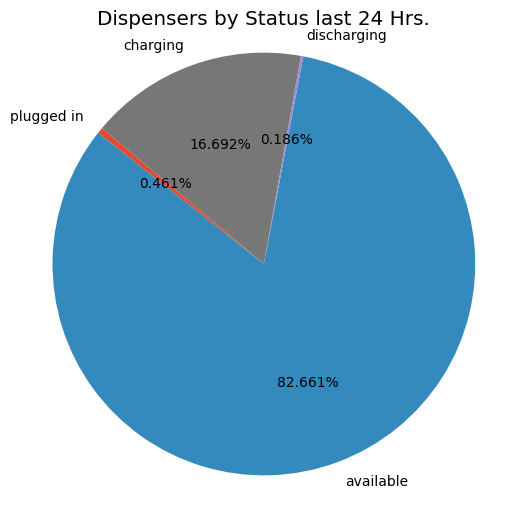

In [301]:
# Pie chart
plt.style.use('ggplot')
plt.figure(figsize=(6, 6))
plt.pie(df['totalPercentage'], labels=df['status'], autopct='%1.3f%%', startangle=140)
plt.title('Dispensers by Status last 24 Hrs.')
plt.axis('equal')  # To be a circle
plt.show()